In [3]:
%matplotlib inline
from astropy.io import fits
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
from astropy import units as u
import aplpy
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import aplpy
import matplotlib as mpl

In [4]:
# -----------------------------  FUNCTIONS -----------------------------
# define normal , double peak normal and linear function
def normal(eta, p0, sig0, eta0):
    return p0 / np.sqrt(2*np.pi*sig0**2) * np.exp(
        -(eta-eta0)**2 / (2*sig0**2))


def double_peak(eta, p0, p1, sig0, sig1, eta0, eta1):
    return (p0 / np.sqrt(2*np.pi*sig0**2) * np.exp(-(eta-eta0)**2 / (2*sig0**2)) + p1 / np.sqrt(2*np.pi*sig1**2) * np.exp(-(eta-eta1)**2 / (2*sig1**2)))


def linear(eta, m, b):
    return m*eta+b

INFO: Auto-setting vmin to  2.106e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.269e+01 [aplpy.core]


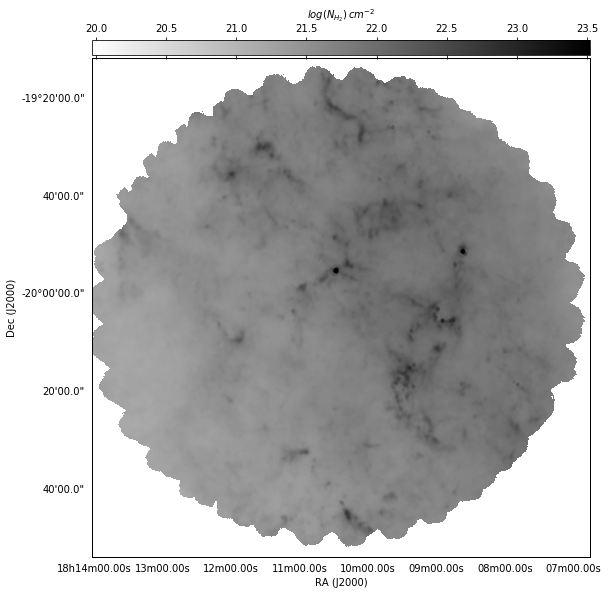

In [9]:
fig = aplpy.FITSFigure('/Users/shjiao/desktop/g10.2/NH2_her_mask.fits',figsize=(9.5,9.5))
#fig.add_beam(major=6*u.arcsecond,minor=6*u.arcsecond,angle=0.0)
#fig.add_label(0.2,0.9, 'column density', color='black', relative=True, size=15,layer='source') 
#fig.add_label(0.92, 0.08, 'Beam: 6\"', relative=True, size='large', layer='title',color='black')
fig.show_grayscale()
fig.add_colorbar()
fig.colorbar.show()
fig.colorbar.set_axis_label_text(r'$log(N_{H_{2}})\, cm^{-2}$')

fig.colorbar.set_location('top')
fig.recenter(272.59838,-20.0529,width=1.7,height=1.7)
fig.show_colorscale(cmap='gist_yarg',vmin= 19.97236,vmax=23.5215)
#fig.colorbar.set_ticks([-0.002,0.,0.002,0.004,0.006])
#fig.show_contour('/Users/shjiao/desktop/g10.2/NH2_her_mask.fits', levels=[21.892689170017178,22.978425374775306], )
#fig.save('/Users/shjiao/desktop/Oph_COS/model_new/combine_step.pdf')
#fig.add_scalebar(0.42441359,"1 pc",color='black', corner='bottom right')
#fig.save('/Users/shjiao/desktop/oph_nh2_contour.pdf')

In [10]:
Nh2_file='/Users/shjiao/desktop/g10.2/NH2_her.fits'
hdu_Nh2=fits.open(Nh2_file)
data_Nh2 = hdu_Nh2[0].data
header_Nh2 = hdu_Nh2[0].header

The N-PDF for N > 10^21 cm-2 region. Two vertical lines show 7.8x10^21 and 9.5x10^22 cm-2 respectively.

1.28776438824e+22
('p:', 1.0189203509615583)
('sigma:', 0.62145330185919301)
('eta', -0.93642737121049324, '\n')
('m:', -3.049171729736678)
('m:', -0.707995501323745)


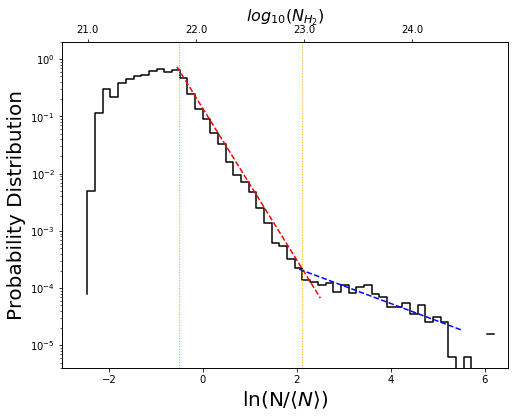

In [11]:
for i in range(0,data_Nh2.shape[0]):
    for j in range(0,data_Nh2.shape[1]):
        if data_Nh2[i][j] < 21.:
            data_Nh2[i][j] = np.nan

data_Nh2_1d = data_Nh2.ravel()
data_Nh2_1d = data_Nh2_1d[~np.isnan(data_Nh2_1d)]

data1 = 10**data_Nh2_1d
# statistic the data
mean = data1.mean()

print mean
# eta = ln(N/N_mean) print('Mean:',mean,'\n')
eta_array =np.log(data1/mean)

prob_den, bins = np.histogram(eta_array, bins=100, density=True)
bin_value = 0.5*(bins[1:]+bins[:-1])
    

# plot the PDF
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
#plt.figure(figsize=(8, 6))
plt.plot(bin_value, prob_den, linestyle='steps-',color='black', linewidth=1.5)
ax.set_ylabel('Probability Distribution', size=20)
ax.set_xlabel(r'ln(N/$\langle N \rangle$)', size=20)
ax.set_yscale('log')
#plt.xscale('log')
ax.set_ylim(0.000004, 2.)
ax.set_xlim(-3, 6.5)
text_mean = str(mean)
text_mean = r'$\langle N \rangle=$'+text_mean[:3]+r'$\times 10^{22}$'

# define the range to fit
fit_lower = -2.5
fit_upper = 0.6
xdata = [bin_value[i] for i in range(len(bin_value)) if (bin_value[i] >= fit_lower) and (bin_value[i] <= fit_upper)]
ydata = [prob_den[i] for i in range(len(bin_value)) if (bin_value[i] >= fit_lower) and (bin_value[i] <= fit_upper)]

# fit the peak curve
popt, pcov = curve_fit(normal,xdata,ydata,p0=[0.5,1,0])
#popt, pcov = curve_fit(double_peak, xdata, ydata,)
print('p:',popt[0])
print('sigma:',popt[1])
print('eta',popt[2],'\n')
# plot the curve
x = np.arange(-3, 3, 0.05)

#fit the power tail
fit_lower=-0.5
fit_upper=2.5
xdata=[bin_value[i] for i in range(len(bin_value)) if (bin_value[i]>=fit_lower) and (bin_value[i]<=fit_upper)]
ydata=[np.log(prob_den[i]) for i in range(len(bin_value)) if (bin_value[i]>=fit_lower) and (bin_value[i]<=fit_upper)]
popt,pcov=curve_fit(linear,xdata,ydata,p0=[-1,1])
print('m:',popt[0])

#plot the power tail
x=np.arange(fit_lower-0.05,fit_upper+0.05,0.05)
y=np.exp(linear(x,popt[0],popt[1]))
ax.plot(x,y,'--',color='red', linewidth=1.5,label='optimal power-law fit')
text_m=str(popt[0])[:7]
text_m='m='+text_m


#fit the power tail
fit_lower=2.1
fit_upper=5.5
xdata=[bin_value[i] for i in range(len(bin_value)) if (bin_value[i]>=fit_lower) and (bin_value[i]<=fit_upper)]
ydata=[np.log(prob_den[i]) for i in range(len(bin_value)) if (bin_value[i]>=fit_lower) and (bin_value[i]<=fit_upper)]
popt,pcov=curve_fit(linear,xdata,ydata,p0=[-1,1])
print('m:',popt[0])

#plot the power tail
x=np.arange(fit_lower-0.05,fit_upper+0.05,0.05)
y=np.exp(linear(x,popt[0],popt[1]))
ax.plot(x,y,'--',color='blue', linewidth=1.5,label='optimal power-law fit')


def tick_function(X):
    V = np.log10(np.exp(X)*mean)
    return ["%.1f" % z for z in V]

new_tick_locations = np.array([-2.4480942949702245, -0.14550920197617884,2.1570758910178669,4.4596609840119124])

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"$log_{10}(N_{H_{2}})$",fontsize=16)


plt.axvline(x=-0.5,linestyle=':',color='orange',linewidth = 1.,)
plt.axvline(x=2.1,linestyle=':',color='orange',linewidth = 1.,)
legend = plt.legend(loc='higher right', shadow=True, fontsize='large',frameon=False)

Assuming M~S850, for each region having similar total mass, I select the 4 region with similar total flux from 850 um image.

# Region 1

INFO: Auto-setting vmin to  2.106e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.269e+01 [aplpy.core]


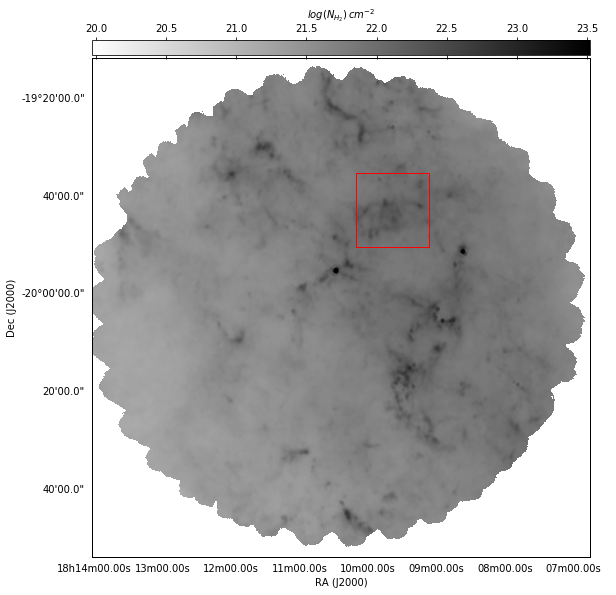

In [27]:
fig = aplpy.FITSFigure('/Users/shjiao/desktop/g10.2/NH2_her_mask.fits',figsize=(9.5,9.5))
fig.show_grayscale()
fig.add_colorbar()
fig.colorbar.show()
fig.colorbar.set_axis_label_text(r'$log(N_{H_{2}})\, cm^{-2}$')

fig.colorbar.set_location('top')
fig.recenter(272.59838,-20.0529,width=1.7,height=1.7)
fig.show_colorscale(cmap='gist_yarg',vmin= 19.97236,vmax=23.5215)
fig.show_rectangles(272.4124525,-19.7194625,0.25,0.25,color='red')

1.24266739759e+22
('p:', 1.1088949899025096)
('sigma:', 0.35581317512476945)
('eta', -0.15430717221909576, '\n')
('m:', -5.7041620239464779)


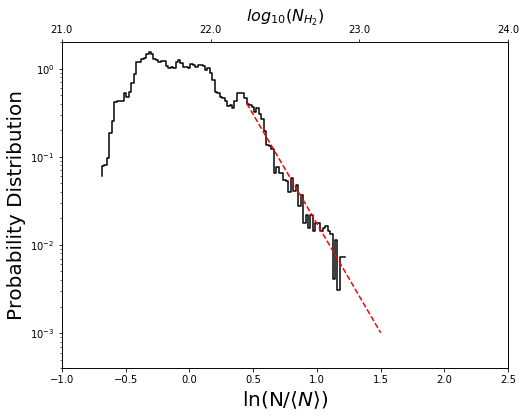

In [24]:
#define the region to statistic
x0=826
y0=926
x1=1050
y1=1149

#crop the region and wipe out nan
data=hdu_Nh2[0].data[y0-1:y1,x0-1:x1]
data=data[data==data].flatten()

data1 = 10**data
# statistic the data
mean = data1.mean()

print mean
# eta = ln(N/N_mean) print('Mean:',mean,'\n')
eta_array =np.log(data1/mean)

prob_den, bins = np.histogram(eta_array, bins=100, density=True)
bin_value = 0.5*(bins[1:]+bins[:-1])
    

# plot the PDF
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
#plt.figure(figsize=(8, 6))
plt.plot(bin_value, prob_den, linestyle='steps-',color='black', linewidth=1.5)
ax.set_ylabel('Probability Distribution', size=20)
ax.set_xlabel(r'ln(N/$\langle N \rangle$)', size=20)
ax.set_yscale('log')
#plt.xscale('log')
ax.set_ylim(0.0004, 2.)
ax.set_xlim(-1., 2.5)
text_mean = str(mean)
text_mean = r'$\langle N \rangle=$'+text_mean[:3]+r'$\times 10^{22}$'

# define the range to fit
fit_lower = -.5
fit_upper = 0.5
xdata = [bin_value[i] for i in range(len(bin_value)) if (bin_value[i] >= fit_lower) and (bin_value[i] <= fit_upper)]
ydata = [prob_den[i] for i in range(len(bin_value)) if (bin_value[i] >= fit_lower) and (bin_value[i] <= fit_upper)]

# fit the peak curve
popt, pcov = curve_fit(normal,xdata,ydata,p0=[0.5,1,0])
#popt, pcov = curve_fit(double_peak, xdata, ydata,)
print('p:',popt[0])
print('sigma:',popt[1])
print('eta',popt[2],'\n')
# plot the curve
x = np.arange(-1, 1., 0.05)
#ax.plot(x, normal(x, popt[0], popt[1], popt[2]),'-', color='green', linewidth=1.5,label='lognormal fit')


#fit the power tail
fit_lower=0.5
fit_upper=1.5
xdata=[bin_value[i] for i in range(len(bin_value)) if (bin_value[i]>=fit_lower) and (bin_value[i]<=fit_upper)]
ydata=[np.log(prob_den[i]) for i in range(len(bin_value)) if (bin_value[i]>=fit_lower) and (bin_value[i]<=fit_upper)]
popt,pcov=curve_fit(linear,xdata,ydata,p0=[-1,1])
print('m:',popt[0])

#plot the power tail
x=np.arange(fit_lower-0.05,fit_upper+0.05,0.05)
y=np.exp(linear(x,popt[0],popt[1]))
ax.plot(x,y,'--',color='red', linewidth=1.5,label='optimal power-law fit')
text_m=str(popt[0])[:7]
text_m='m='+text_m



def tick_function(X):
    V = np.log10(np.exp(X)*mean)
    return ["%.1f" % z for z in V]

new_tick_locations = np.array([-2.4480942949702245, -0.14550920197617884,2.1570758910178669,4.4596609840119124])

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"$log_{10}(N_{H_{2}})$",fontsize=16)


#plt.axvline(x=-0.5,linestyle=':',color='orange',linewidth = 1.,)
#plt.axvline(x=2.1,linestyle=':',color='orange',linewidth = 1.,)
legend = plt.legend(loc='higher right', shadow=True, fontsize='large',frameon=False)

# Region 2

INFO: Auto-setting vmin to  2.106e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.269e+01 [aplpy.core]


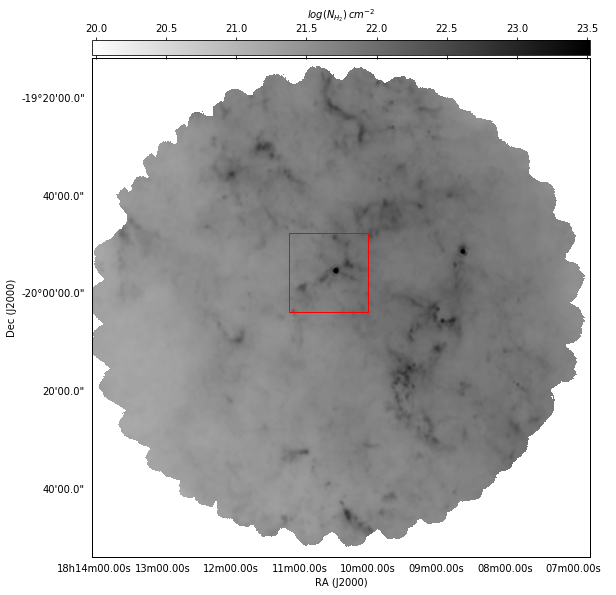

In [28]:
fig = aplpy.FITSFigure('/Users/shjiao/desktop/g10.2/NH2_her_mask.fits',figsize=(9.5,9.5))
fig.show_grayscale()
fig.add_colorbar()
fig.colorbar.show()
fig.colorbar.set_axis_label_text(r'$log(N_{H_{2}})\, cm^{-2}$')

fig.colorbar.set_location('top')
fig.recenter(272.59838,-20.0529,width=1.7,height=1.7)
fig.show_colorscale(cmap='gist_yarg',vmin= 19.97236,vmax=23.5215)
fig.show_rectangles(272.6450977,-19.93191044,0.27,0.27,color='red')

1.11776089673e+22
('p:', 0.78635821393623451)
('sigma:', 0.33087115455310379)
('eta', -0.28388297349319913, '\n')
('m:', -3.1748255495517501)
('m:', -0.22833738202104081)


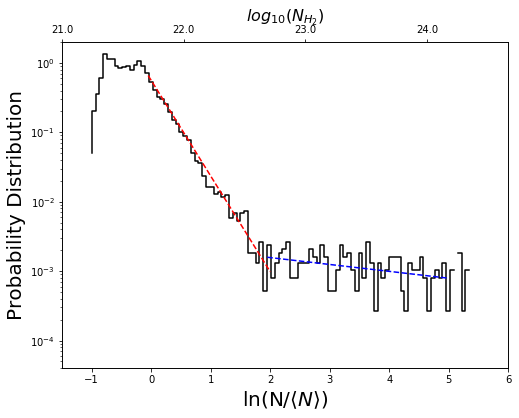

In [48]:
#define the region to statistic
x0=617
y0=723
x1=859
y1=967

#crop the region and wipe out nan
data=hdu_Nh2[0].data[y0-1:y1,x0-1:x1]
data=data[data==data].flatten()

data1 = 10**data
# statistic the data
mean = data1.mean()

print mean
# eta = ln(N/N_mean) print('Mean:',mean,'\n')
eta_array =np.log(data1/mean)

prob_den, bins = np.histogram(eta_array, bins=100, density=True)
bin_value = 0.5*(bins[1:]+bins[:-1])
    

# plot the PDF
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
#plt.figure(figsize=(8, 6))
plt.plot(bin_value, prob_den, linestyle='steps-',color='black', linewidth=1.5)
ax.set_ylabel('Probability Distribution', size=20)
ax.set_xlabel(r'ln(N/$\langle N \rangle$)', size=20)
ax.set_yscale('log')
#plt.xscale('log')
ax.set_ylim(0.00004, 2.)
ax.set_xlim(-1.5, 6.)
text_mean = str(mean)
text_mean = r'$\langle N \rangle=$'+text_mean[:3]+r'$\times 10^{22}$'

# define the range to fit
fit_lower = -.5
fit_upper = 0.5
xdata = [bin_value[i] for i in range(len(bin_value)) if (bin_value[i] >= fit_lower) and (bin_value[i] <= fit_upper)]
ydata = [prob_den[i] for i in range(len(bin_value)) if (bin_value[i] >= fit_lower) and (bin_value[i] <= fit_upper)]

# fit the peak curve
popt, pcov = curve_fit(normal,xdata,ydata,p0=[0.5,1,0])
#popt, pcov = curve_fit(double_peak, xdata, ydata,)
print('p:',popt[0])
print('sigma:',popt[1])
print('eta',popt[2],'\n')
# plot the curve
x = np.arange(-1, 1., 0.05)
#ax.plot(x, normal(x, popt[0], popt[1], popt[2]),'-', color='green', linewidth=1.5,label='lognormal fit')


#fit the power tail
fit_lower=0.
fit_upper=2.
xdata=[bin_value[i] for i in range(len(bin_value)) if (bin_value[i]>=fit_lower) and (bin_value[i]<=fit_upper)]
ydata=[np.log(prob_den[i]) for i in range(len(bin_value)) if (bin_value[i]>=fit_lower) and (bin_value[i]<=fit_upper)]
popt,pcov=curve_fit(linear,xdata,ydata,p0=[-1,1])
print('m:',popt[0])

#plot the power tail
x=np.arange(fit_lower-0.05,fit_upper+0.05,0.05)
y=np.exp(linear(x,popt[0],popt[1]))
ax.plot(x,y,'--',color='red', linewidth=1.5,label='optimal power-law fit')
text_m=str(popt[0])[:7]



#fit the power tail

fit_lower_sec=2.
fit_upper_sec=5.
xdata_sec=[bin_value[i] for i in range(len(bin_value)) if (bin_value[i]>=fit_lower_sec) and (bin_value[i]<=fit_upper_sec)]
ydata_sec=[np.log(prob_den[i]) for i in range(len(bin_value)) if (bin_value[i]>=fit_lower_sec) and (bin_value[i]<=fit_upper_sec)]

for i in range(0,len(ydata_sec)):
    if np.isinf(ydata_sec[i]):
        ydata_sec[i]=0.

popt_sec,pcov_sec=curve_fit(linear,xdata_sec,ydata_sec,p0=[-1,1])
print('m:',popt_sec[0])


#plot the power tail
x_sec=np.arange(fit_lower_sec-0.05,fit_upper_sec+0.05,0.05)
y_sec=np.exp(linear(x_sec,popt_sec[0],popt_sec[1]))
ax.plot(x_sec,y_sec,'--',color='blue', linewidth=1.5,label='optimal power-law fit')


def tick_function(X):
    V = np.log10(np.exp(X)*mean)
    return ["%.1f" % z for z in V]

new_tick_locations = np.array([-2.4480942949702245, -0.14550920197617884,2.1570758910178669,4.4596609840119124])

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"$log_{10}(N_{H_{2}})$",fontsize=16)


#plt.axvline(x=-0.5,linestyle=':',color='orange',linewidth = 1.,)
#plt.axvline(x=2.1,linestyle=':',color='orange',linewidth = 1.,)
legend = plt.legend(loc='higher right', shadow=True, fontsize='large',frameon=False)

# Region 3

INFO: Auto-setting vmin to  2.106e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.269e+01 [aplpy.core]


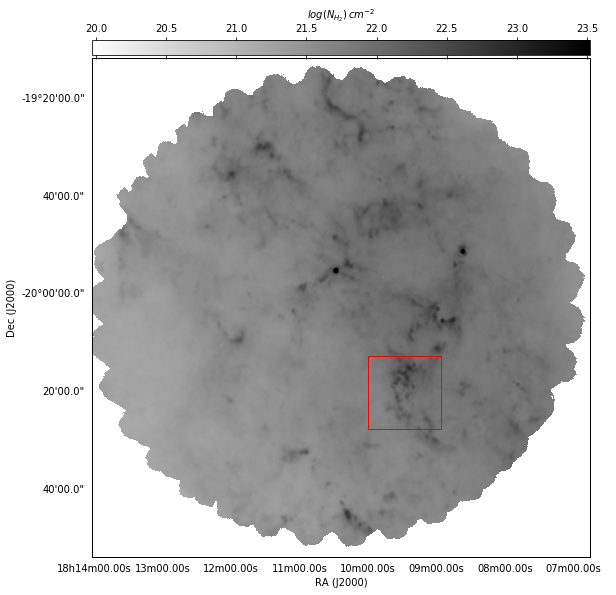

In [49]:
fig = aplpy.FITSFigure('/Users/shjiao/desktop/g10.2/NH2_her_mask.fits',figsize=(9.5,9.5))
fig.show_grayscale()
fig.add_colorbar()
fig.colorbar.show()
fig.colorbar.set_axis_label_text(r'$log(N_{H_{2}})\, cm^{-2}$')

fig.colorbar.set_location('top')
fig.recenter(272.59838,-20.0529,width=1.7,height=1.7)
fig.show_colorscale(cmap='gist_yarg',vmin= 19.97236,vmax=23.5215)
fig.show_rectangles(272.3691737,-20.34313528,0.25,0.25,color='red')

1.0931875037e+22
('p:', 0.94994587017489263)
('sigma:', 0.45362743312305609)
('eta', -0.25865516027334196, '\n')
('m:', -2.3038051423046277)


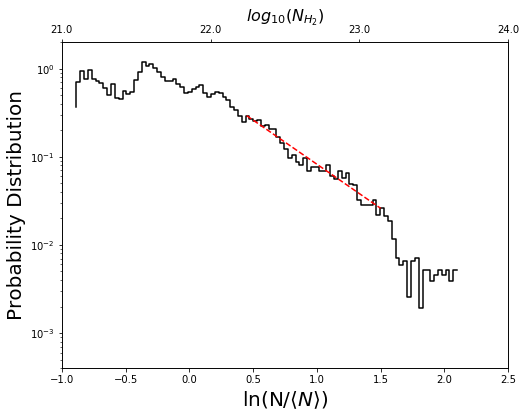

In [50]:
#define the region to statistic
x0=859
y0=364
x1=1085
y1=588

#crop the region and wipe out nan
data=hdu_Nh2[0].data[y0-1:y1,x0-1:x1]
data=data[data==data].flatten()

data1 = 10**data
# statistic the data
mean = data1.mean()

print mean
# eta = ln(N/N_mean) print('Mean:',mean,'\n')
eta_array =np.log(data1/mean)

prob_den, bins = np.histogram(eta_array, bins=100, density=True)
bin_value = 0.5*(bins[1:]+bins[:-1])
    

# plot the PDF
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
#plt.figure(figsize=(8, 6))
plt.plot(bin_value, prob_den, linestyle='steps-',color='black', linewidth=1.5)
ax.set_ylabel('Probability Distribution', size=20)
ax.set_xlabel(r'ln(N/$\langle N \rangle$)', size=20)
ax.set_yscale('log')
#plt.xscale('log')
ax.set_ylim(0.0004, 2.)
ax.set_xlim(-1., 2.5)
text_mean = str(mean)
text_mean = r'$\langle N \rangle=$'+text_mean[:3]+r'$\times 10^{22}$'

# define the range to fit
fit_lower = -.5
fit_upper = 0.5
xdata = [bin_value[i] for i in range(len(bin_value)) if (bin_value[i] >= fit_lower) and (bin_value[i] <= fit_upper)]
ydata = [prob_den[i] for i in range(len(bin_value)) if (bin_value[i] >= fit_lower) and (bin_value[i] <= fit_upper)]

# fit the peak curve
popt, pcov = curve_fit(normal,xdata,ydata,p0=[0.5,1,0])
#popt, pcov = curve_fit(double_peak, xdata, ydata,)
print('p:',popt[0])
print('sigma:',popt[1])
print('eta',popt[2],'\n')
# plot the curve
x = np.arange(-1, 1., 0.05)
#ax.plot(x, normal(x, popt[0], popt[1], popt[2]),'-', color='green', linewidth=1.5,label='lognormal fit')


#fit the power tail
fit_lower=0.5
fit_upper=1.5
xdata=[bin_value[i] for i in range(len(bin_value)) if (bin_value[i]>=fit_lower) and (bin_value[i]<=fit_upper)]
ydata=[np.log(prob_den[i]) for i in range(len(bin_value)) if (bin_value[i]>=fit_lower) and (bin_value[i]<=fit_upper)]
popt,pcov=curve_fit(linear,xdata,ydata,p0=[-1,1])
print('m:',popt[0])

#plot the power tail
x=np.arange(fit_lower-0.05,fit_upper+0.05,0.05)
y=np.exp(linear(x,popt[0],popt[1]))
ax.plot(x,y,'--',color='red', linewidth=1.5,label='optimal power-law fit')
text_m=str(popt[0])[:7]
text_m='m='+text_m



def tick_function(X):
    V = np.log10(np.exp(X)*mean)
    return ["%.1f" % z for z in V]

new_tick_locations = np.array([-2.4480942949702245, -0.14550920197617884,2.1570758910178669,4.4596609840119124])

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"$log_{10}(N_{H_{2}})$",fontsize=16)


#plt.axvline(x=-0.5,linestyle=':',color='orange',linewidth = 1.,)
#plt.axvline(x=2.1,linestyle=':',color='orange',linewidth = 1.,)
legend = plt.legend(loc='higher right', shadow=True, fontsize='large',frameon=False)

# Region 4

INFO: Auto-setting vmin to  2.106e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.269e+01 [aplpy.core]


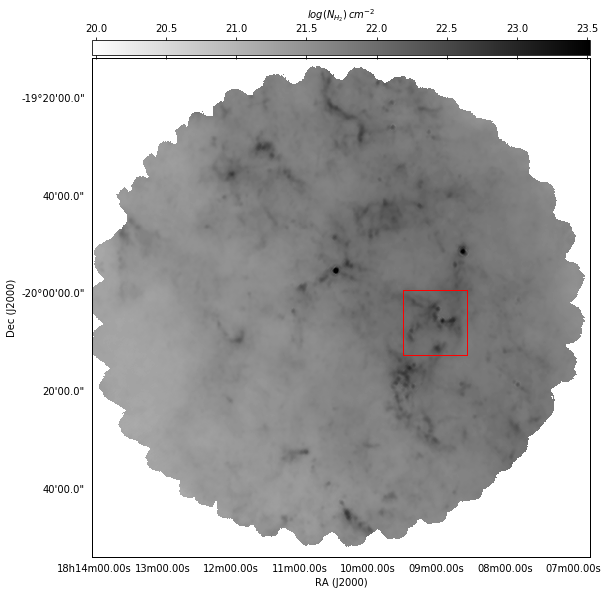

In [51]:
fig = aplpy.FITSFigure('/Users/shjiao/desktop/g10.2/NH2_her_mask.fits',figsize=(9.5,9.5))
fig.show_grayscale()
fig.add_colorbar()
fig.colorbar.show()
fig.colorbar.set_axis_label_text(r'$log(N_{H_{2}})\, cm^{-2}$')

fig.colorbar.set_location('top')
fig.recenter(272.59838,-20.0529,width=1.7,height=1.7)
fig.show_colorscale(cmap='gist_yarg',vmin= 19.97236,vmax=23.5215)
fig.show_rectangles(272.2576958,-20.10294778,0.22,0.22,color='red')

1.53146215409e+22
('p:', 1.5039606280368465)
('sigma:', 0.46247696292790902)
('eta', -0.40471407156306316, '\n')
('m:', -2.9326424047145436)


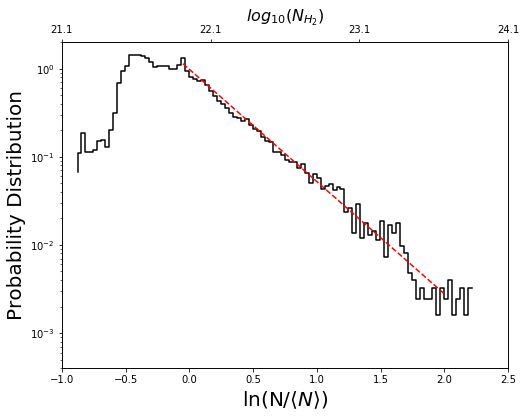

In [54]:
#define the region to statistic
x0=967
y0=591
x1=1167
y1=788

#crop the region and wipe out nan
data=hdu_Nh2[0].data[y0-1:y1,x0-1:x1]
data=data[data==data].flatten()

data1 = 10**data
# statistic the data
mean = data1.mean()

print mean
# eta = ln(N/N_mean) print('Mean:',mean,'\n')
eta_array =np.log(data1/mean)

prob_den, bins = np.histogram(eta_array, bins=100, density=True)
bin_value = 0.5*(bins[1:]+bins[:-1])
    

# plot the PDF
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
#plt.figure(figsize=(8, 6))
plt.plot(bin_value, prob_den, linestyle='steps-',color='black', linewidth=1.5)
ax.set_ylabel('Probability Distribution', size=20)
ax.set_xlabel(r'ln(N/$\langle N \rangle$)', size=20)
ax.set_yscale('log')
#plt.xscale('log')
ax.set_ylim(0.0004, 2.)
ax.set_xlim(-1., 2.5)
text_mean = str(mean)
text_mean = r'$\langle N \rangle=$'+text_mean[:3]+r'$\times 10^{22}$'

# define the range to fit
fit_lower = -.5
fit_upper = 0.5
xdata = [bin_value[i] for i in range(len(bin_value)) if (bin_value[i] >= fit_lower) and (bin_value[i] <= fit_upper)]
ydata = [prob_den[i] for i in range(len(bin_value)) if (bin_value[i] >= fit_lower) and (bin_value[i] <= fit_upper)]

# fit the peak curve
popt, pcov = curve_fit(normal,xdata,ydata,p0=[0.5,1,0])
#popt, pcov = curve_fit(double_peak, xdata, ydata,)
print('p:',popt[0])
print('sigma:',popt[1])
print('eta',popt[2],'\n')
# plot the curve
x = np.arange(-1, 1., 0.05)
#ax.plot(x, normal(x, popt[0], popt[1], popt[2]),'-', color='green', linewidth=1.5,label='lognormal fit')


#fit the power tail
fit_lower=-0.
fit_upper=2.
xdata=[bin_value[i] for i in range(len(bin_value)) if (bin_value[i]>=fit_lower) and (bin_value[i]<=fit_upper)]
ydata=[np.log(prob_den[i]) for i in range(len(bin_value)) if (bin_value[i]>=fit_lower) and (bin_value[i]<=fit_upper)]
popt,pcov=curve_fit(linear,xdata,ydata,p0=[-1,1])
print('m:',popt[0])

#plot the power tail
x=np.arange(fit_lower-0.05,fit_upper+0.05,0.05)
y=np.exp(linear(x,popt[0],popt[1]))
ax.plot(x,y,'--',color='red', linewidth=1.5,label='optimal power-law fit')
text_m=str(popt[0])[:7]
text_m='m='+text_m



def tick_function(X):
    V = np.log10(np.exp(X)*mean)
    return ["%.1f" % z for z in V]

new_tick_locations = np.array([-2.4480942949702245, -0.14550920197617884,2.1570758910178669,4.4596609840119124])

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"$log_{10}(N_{H_{2}})$",fontsize=16)


#plt.axvline(x=-0.5,linestyle=':',color='orange',linewidth = 1.,)
#plt.axvline(x=2.1,linestyle=':',color='orange',linewidth = 1.,)
legend = plt.legend(loc='higher right', shadow=True, fontsize='large',frameon=False)